In [2]:
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
import xarray as xr
from scipy import interpolate

from datetime import timedelta as delta

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy



In [3]:
data_path = '/storage/shared/oceanparcels/input_data/'

file_path = data_path + 'CMEMS/NWSHELF_MULTIYEAR_PHY_004_009/metoffice_foam1_amm7_NWS_CUR_dm20141202.nc'
model = xr.open_dataset(file_path)
model

<xarray.Dataset>
Dimensions:    (time: 1, depth: 24, latitude: 375, longitude: 297)
Coordinates:
  * time       (time) datetime64[ns] 2014-12-02T12:00:00
  * depth      (depth) float32 0.0 3.0 10.0 15.0 ... 2e+03 3e+03 4e+03 5e+03
  * latitude   (latitude) float32 40.07 40.13 40.2 40.27 ... 64.87 64.93 65.0
  * longitude  (longitude) float32 -19.89 -19.78 -19.67 ... 12.78 12.89 13.0
Data variables:
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
Attributes: (12/13)
    title:                daily-mean horizontal velocity (3D)
    Conventions:          CF-1.7
    references:           http://marine.copernicus.eu/
    institution:          UK Met Office
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    ...                   ...
    source:               AMM-FOAM 7 km (tidal) NEMO v3.6_FABM-ERSEM v15.06_N...
    product:              NWSHELF_MULTIYEAR_PHY_004_009
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF; ERA5
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    history:              See source and creation_date attributes

In [21]:
def make_landmask(fielddata):
    """Returns landmask where land = 1 and ocean = 0
    fielddata is a netcdf file.
    """
    datafile = Dataset(fielddata)

    landmask = datafile.variables['uo'][0, 0]
    landmask = np.ma.masked_invalid(landmask)
    landmask = landmask.mask.astype('int')

    return landmask

def get_coastal_nodes(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes directly
    next to land. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype('int')

    return coastal

def get_shore_nodes(landmask):
    """Function that detects the shore nodes, i.e. the land nodes directly
    next to the ocean. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype('int')

    return shore

def get_coastal_nodes_diagonal(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes where 
    one of the 8 nearest nodes is land. Computes the Laplacian of landmask
    and the Laplacian of the 45 degree rotated landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap += np.roll(landmask, (-1,1), axis=(0,1)) + np.roll(landmask, (1, 1), axis=(0,1))
    mask_lap += np.roll(landmask, (-1,-1), axis=(0,1)) + np.roll(landmask, (1, -1), axis=(0,1))
    mask_lap -= 8*landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype('int')
    
    return coastal
    
def get_shore_nodes_diagonal(landmask):
    """Function that detects the shore nodes, i.e. the land nodes where 
    one of the 8 nearest nodes is ocean. Computes the Laplacian of landmask 
    and the Laplacian of the 45 degree rotated landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap += np.roll(landmask, (-1,1), axis=(0,1)) + np.roll(landmask, (1, 1), axis=(0,1))
    mask_lap += np.roll(landmask, (-1,-1), axis=(0,1)) + np.roll(landmask, (1, -1), axis=(0,1))
    mask_lap -= 8*landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype('int')

    return shore

def create_displacement_field(landmask, double_cell=False):
    """Function that creates a displacement field 1 m/s away from the shore.

    - landmask: the land mask dUilt using `make_landmask`.
    - double_cell: Boolean for determining if you want a double cell.
      Default set to False.

    Output: two 2D arrays, one for each camponent of the velocity.
    """
    shore = get_shore_nodes(landmask)
    shore_d = get_shore_nodes_diagonal(landmask) # bordering ocean directly and diagonally
    shore_c = shore_d - shore                    # corner nodes that only border ocean diagonally
    
    Ly = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0) # Simple derivative
    Lx = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
    
    Ly_c = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
    Ly_c += np.roll(landmask, (-1,-1), axis=(0,1)) + np.roll(landmask, (-1,1), axis=(0,1)) # Include y-component of diagonal neighbours
    Ly_c += - np.roll(landmask, (1,-1), axis=(0,1)) - np.roll(landmask, (1,1), axis=(0,1))
    
    Lx_c = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
    Lx_c += np.roll(landmask, (-1,-1), axis=(1,0)) + np.roll(landmask, (-1,1), axis=(1,0)) # Include x-component of diagonal neighbours
    Lx_c += - np.roll(landmask, (1,-1), axis=(1,0)) - np.roll(landmask, (1,1), axis=(1,0))
    
    v_x = -Lx*(shore)
    v_y = -Ly*(shore)
    
    v_x_c = -Lx_c*(shore_c)
    v_y_c = -Ly_c*(shore_c)
    
    v_x = v_x + v_x_c
    v_y = v_y + v_y_c

    magnitude = np.sqrt(v_y**2 + v_x**2)
    # the coastal nodes between land create a problem. Magnitude there is zero
    # I force it to be 1 to avoid problems when normalizing.
    ny, nx = np.where(magnitude == 0)
    magnitude[ny, nx] = 1

    v_x = v_x/magnitude
    v_y = v_y/magnitude

    return v_x, v_y

def distance_to_shore(landmask, dx=1):
    """Function that computes the distance to the shore. It is based in the
    the `get_coastal_nodes` algorithm.

    - landmask: the land mask dUilt using `make_landmask` function.
    - dx: the grid cell dimension. This is a crude approxsimation of the real
    distance (be careful).

    Output: 2D array containing the distances from shore.
    """
    ci = get_coastal_nodes(landmask) # direct neighbours
    dist = ci*dx                     # 1 dx away
    
    ci_d = get_coastal_nodes_diagonal(landmask) # diagonal neighbours
    dist_d = (ci_d - ci)*np.sqrt(2*dx**2)       # sqrt(2) dx away
        
    return dist+dist_d

In [5]:


# --------- Define meshgrid coordinates to plot velocity field with matplotlib pcolormesh ---------
latmin = 10
latmax = 364
lonmin = 10
lonmax = 269

# Velocity nodes
lon_vals, lat_vals = np.meshgrid(model['longitude'], model['latitude'])
lons_plot = lon_vals[latmin:latmax,lonmin:lonmax]
lats_plot = lat_vals[latmin:latmax,lonmin:lonmax]

dlon = 1/12
dlat = 1/12

# Centers of the gridcells formed by 4 nodes = velocity nodes + 0.5 dx
x = model['longitude'][:-1]+np.diff(model['longitude'])/2
y = model['latitude'][:-1]+np.diff(model['latitude'])/2
lon_centers, lat_centers = np.meshgrid(x, y)

color_land = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(128)



landmask = make_landmask(file_path)



# Interpolate the landmask to the cell centers - only cells with 4 neighbouring land points will be land
fl = interpolate.interp2d(model['longitude'],model['latitude'],landmask)

l_centers = fl(lon_centers[0,:],lat_centers[:,0])  

lmask = np.ma.masked_values(l_centers,1) # land when interpolated value == 1




In [26]:
lmask.shape

(374, 296)

In [27]:
np.savetxt('new/landMask_296x_374y',lmask)

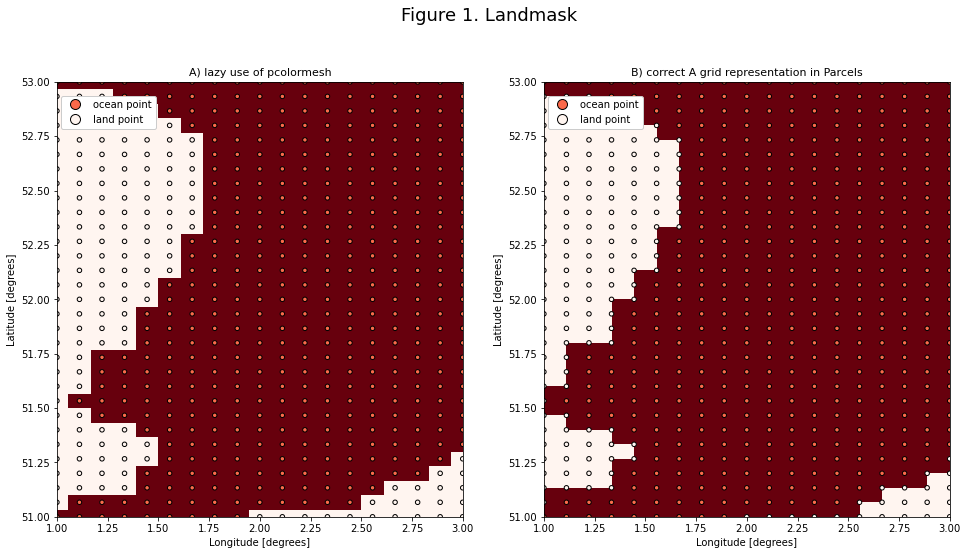

In [17]:


fig = plt.figure(figsize=(16,8))
fig.suptitle('Figure 1. Landmask', fontsize=18, y=1.01)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_title('A) lazy use of pcolormesh', fontsize=11)
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

land0 = ax0.pcolormesh(lons_plot, lats_plot, landmask[latmin:latmax,lonmin:lonmax],cmap='Reds_r', shading='auto')
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05,edgecolors='k')

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax0.legend(custom_lines, ['ocean point', 'land point'], bbox_to_anchor=(.01,.93), loc='center left', borderaxespad=0.,framealpha=1)
ax0.set_xlim(1,3)
ax0.set_ylim(51,53)

ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title('B) correct A grid representation in Parcels', fontsize=11)
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')

land1 = ax1.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax1.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05,edgecolors='k')
ax1.set_xlim(1,3)
ax1.set_ylim(51,53)
ax1.legend(custom_lines, ['ocean point', 'land point'], bbox_to_anchor=(.01,.93), loc='center left', borderaxespad=0.,framealpha=1)



In [11]:


coastal = get_coastal_nodes_diagonal(landmask)
shore = get_shore_nodes_diagonal(landmask)



In [30]:
shore.shape

(375, 297)

In [35]:
np.savetxt('new/coastalMask_297x_375y',coastal)
np.savetxt('new/shoreMask_297x_375y',shore)

(51.0, 53.0)

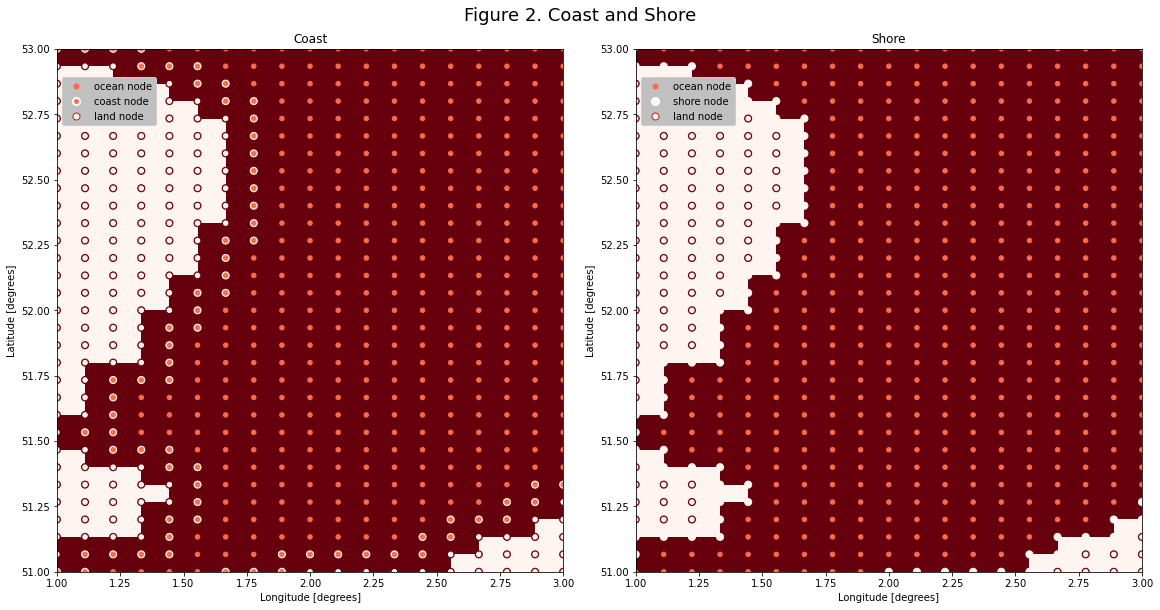

In [15]:
fig = plt.figure(figsize=(16,8), constrained_layout=True)
fig.suptitle('Figure 2. Coast and Shore', fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)


ax0 = fig.add_subplot(gs[0, 0])
land0 = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
coa = ax0.scatter(lons_plot,lats_plot, c=coastal[latmin:latmax,lonmin:lonmax], cmap='Reds_r', s=50)
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05)

ax0.set_title('Coast')
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')
ax0.set_xlim(1,3)
ax0.set_ylim(51,53)
custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=5, lw=0),
                Line2D([0], [0], c = color_ocean, marker='o', markersize=7, markeredgecolor='w', markeredgewidth=2, lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=7, markeredgecolor='firebrick', lw=0)]
ax0.legend(custom_lines, ['ocean node', 'coast node', 'land node'], bbox_to_anchor=(.01,.9), loc='center left', borderaxespad=0.,framealpha=1, facecolor='silver')


ax1 = fig.add_subplot(gs[0, 1])
land1 = ax1.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
sho = ax1.scatter(lons_plot,lats_plot, c=shore[latmin:latmax,lonmin:lonmax], cmap='Reds_r', s=50)
ax1.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05)

ax1.set_title('Shore')
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=5, lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=7, markeredgecolor='w', markeredgewidth=2, lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=7, markeredgecolor='firebrick', lw=0)]
ax1.legend(custom_lines, ['ocean node', 'shore node', 'land node'], bbox_to_anchor=(.01,.9), loc='center left', borderaxespad=0.,framealpha=1, facecolor='silver')


ax1.set_xlim(1,3)
ax1.set_ylim(51,53)



In [18]:


v_x, v_y = create_displacement_field(landmask)



In [33]:
v_x.shape, v_y.shape

((375, 297), (375, 297))

In [36]:
np.savetxt('new/displacementV_x_297x_375y',v_x)
np.savetxt('new/displacementV_y_297x_375y',v_y)


(51.0, 53.0)

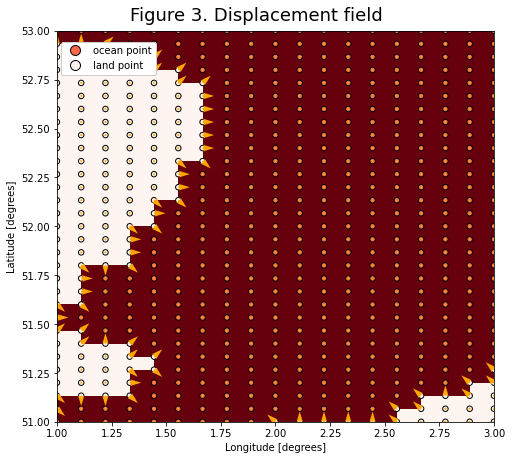

In [19]:
fig = plt.figure(figsize=(7,6), constrained_layout=True)
fig.suptitle('Figure 3. Displacement field', fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
land = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=30,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
quiv = ax0.quiver(lons_plot,lats_plot,v_x[latmin:latmax,lonmin:lonmax],v_y[latmin:latmax,lonmin:lonmax],color='orange',angles='xy', scale_units='xy', scale=19, width=0.005)

ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax0.legend(custom_lines, ['ocean point', 'land point'], bbox_to_anchor=(.01,.93), loc='center left', borderaxespad=0.,framealpha=1)
ax0.set_xlim(1,3)
ax0.set_ylim(51,53)

In [22]:


d_2_s = distance_to_shore(landmask)



In [37]:
d_2_s.shape

(375, 297)

In [38]:
np.savetxt('new/d2shore_297x_375y',d_2_s)


(51.0, 53.0)

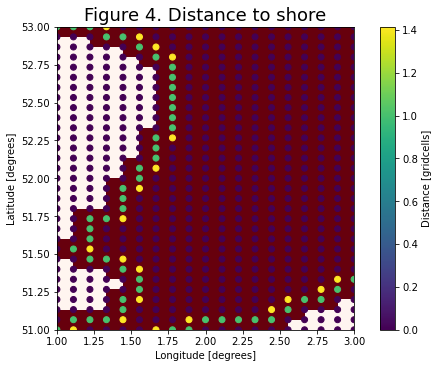

In [24]:


fig = plt.figure(figsize=(6,5), constrained_layout=True)

ax0 = fig.add_subplot()
ax0.set_title('Figure 4. Distance to shore', fontsize=18)
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

land = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
d2s = ax0.scatter(lons_plot,lats_plot, c=d_2_s[latmin:latmax,lonmin:lonmax])

plt.colorbar(d2s,ax=ax0, label='Distance [gridcells]')

ax0.set_xlim(1,3)
ax0.set_ylim(51,53)